# Test Parallel Processing

This script is used to test the parallel processing.

In [1]:
# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# or uncomment the code below

from platform import python_version

print('The current Python version is', python_version())

import hddm, IPython
print('The current HDDM version is', hddm.__version__) # 0.8.0

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
#print('The current IPython version is', IPython.__version__) 

Notebook is running: /opt/conda/bin/python
The current Python version is 3.7.6
The current HDDM version is 0.8.0


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
#!conda list

In [3]:
%matplotlib inline

# Preparation
import os, time, csv, datetime
import kabuki, hddm
from kabuki.analyze import gelman_rubin

from datetime import date

import random
import pandas as pd
import matplotlib.pyplot as plt

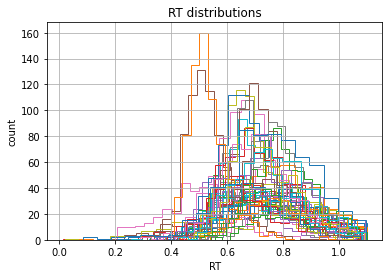

In [4]:
# get the directy of the current folder in docker
#cur_dir = os.getcwd()

# load data
df1a = hddm.load_csv('/home/jovyan/hddm/df1a.v.hddm_stim.csv')

df1a.head(10)  # uncomment if you want to check the head of the data

# Uncomment the codes below if you are interested in checking the distribution of raw data
# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in df1a.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# plt.savefig('plot_MS_dat_M_match.pdf')

In [5]:
# define a function to run model in parallel
def run_model(id):
    print('running model%i'%id);
    
    import hddm
    import random
    #import os
    
    #cur_dir = os.getcwd()

    exp_name = '1a'
    print('running models %i'%id, 'for for exp', exp_name)
    
    # USE the absolute directory in docker.
    dbname = '/home/jovyan/hddm/df' + exp_name + '_chain_vaz_test_%i.db'%id # define the database name, which uses pickle format
    mname  = '/home/jovyan/hddm/df' + exp_name + '_chain__vaz_test_%i'%id    # define the name for the model
    fname  = '/home/jovyan/hddm/df' + exp_name + '.v.hddm_stim.csv'
    df1a = hddm.load_csv(fname)

    df1a_subj = df1a['subj_idx'].unique()

    # random select without repetition
    random.seed(10)
    df1a_test_list = []
    for i in range(10):
        pos = random.randint(0, (len(df1a_subj)-1))
        df1a_test_list.append(df1a_subj[pos])  
    
    df1a_test = df1a[df1a['subj_idx'].isin(df1a_test_list)]
    
    m = hddm.HDDMStimCoding(df1a_test, 
                            include='z', 
                            stim_col='stim', 
                            depends_on={'v':['match','val'], 'a':['match','val']},
                            split_param='v', 
                            drift_criterion=False,
                            p_outlier=0.05)
    m.find_starting_values()
    m.sample(1000, burn=500, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

### Test single chain

In [6]:
start_time = time.time()  # the start time of the processing

m = run_model(0)

print("\nRunning 1 chain used: %f seconds." % (time.time() - start_time))

running model0
running models 0 for for exp 1a


/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 1001 of 1000 complete in 245.4 sec
Running 1 chain used: 259.815360 seconds.


In [7]:
print("M_df1a_v_corr DIC: %f" % m.dic) 

M_df1a_v_corr DIC: 567.328421


### Test multiple chains in parallel

In [8]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

# Running 4 chains used: 487.836930 seconds (dell-5510)
# Running 4 chains used: 311.741371 seconds (thinkpad-x1)


Running 4 chains used: 327.374537 seconds.


In [10]:
print("M_df1a_v_corr DIC: %f" % models[0].dic) 

gelman_rubin(models)

M_df1a_v_corr DIC: 567.066417


{'a(Match.Bad)': 1.0010500017881263,
 'a(Match.Good)': 1.0077663985189396,
 'a(Match.Neutral)': 0.9992959080087257,
 'a(Mismatch.Bad)': 1.0027647153761323,
 'a(Mismatch.Good)': 0.9999967817354265,
 'a(Mismatch.Neutral)': 1.0008467301115278,
 'a_std': 1.0025882514741153,
 'a_subj(Match.Bad).1001': 0.9999346416064712,
 'a_subj(Match.Good).1001': 1.001447016126142,
 'a_subj(Match.Neutral).1001': 0.9999591837373868,
 'a_subj(Match.Bad).1003': 0.999240530746335,
 'a_subj(Match.Good).1003': 0.9996646449625582,
 'a_subj(Match.Neutral).1003': 1.0019879981403768,
 'a_subj(Match.Bad).1015': 0.9997390938128513,
 'a_subj(Match.Good).1015': 1.0023897376436994,
 'a_subj(Match.Neutral).1015': 1.0014786070670831,
 'a_subj(Match.Bad).1021': 1.0030481821856514,
 'a_subj(Match.Good).1021': 0.9991453277704129,
 'a_subj(Match.Neutral).1021': 1.000191218606693,
 'a_subj(Match.Bad).1031': 1.0024034085749454,
 'a_subj(Match.Good).1031': 1.0018276509078248,
 'a_subj(Match.Neutral).1031': 0.999322670862535,
 'a

In [11]:
# Create a new model that has all traces concatenated
# of individual models.
import kabuki
combined_model = kabuki.utils.concat_models(models)

### Test multiple chain with progress bar

In [4]:
#-------------------------------
# Watcher function - function for dynamically printing ipython parallel output 
# adapted from the following two sources:
# http://stackoverflow.com/questions/18086299/real-time-output-from-engines-in-ipython-parallel
# http://stackoverflow.com/questions/15289168/printing-to-stdout-in-ipython-parallel-processes
#-------------------------------       
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=30):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output
    """
    ## ar: 
    ## 
    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [5]:
from ipyparallel import Client
start_time = time.time()  # the start time of the processing
v = Client()[:]
jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
wait_watching_stdout(jobs)
models = jobs.get()

m1_time = time.time() 
print("\nRunning 4 chains used: %f seconds." % (m1_time - start_time))

------------------------------
300.581s elapsed

running model0
running models 0 for for exp 1a
 [-----------------100%-----------------] 1000 of 1000 complete in 283.6 sec
running model1
running models 1 for for exp 1a
 [-----------------100%-----------------] 1000 of 1000 complete in 283.1 sec
running model2
running models 2 for for exp 1a
 [-----------------98%----------------- ] 981 of 1000 complete in 282.3 sec
running model3
running models 3 for for exp 1a
 [-----------------98%----------------- ] 987 of 1000 complete in 282.9 sec



Running 4 chains used: 330.669825 seconds.


#### Testing ipyparallel


Test computing using examples from this [tutorial](http://people.duke.edu/~ccc14/sta-663-2016/19C_IPyParallel.html).

In [5]:
import ipyparallel as ipp
rc = ipp.Client()
rc.ids

[0, 1, 2, 3]

In [6]:
def foo():
    import time
    time.sleep(5)
    return 'foo'

def bar():
    import time
    time.sleep(10) 
    return 'bar'  

res1 = rc[0].apply(foo)
res2 = rc[1].apply(bar)
results = [res1, res2]

while not all(map(lambda ar: ar.ready(), results)):
    pass

print(res1.get(), res2.get())

foo bar


In [7]:
dv = rc[:]

In [8]:
dv.map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [9]:
rc[::2].map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [10]:
rc[2].map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))


[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [11]:
lv = rc.load_balanced_view()

In [13]:
import numpy as np
lv.map_sync(lambda x: sum(x), np.random.random((10, 100000)))

[49957.16139468544,
 49955.61971922777,
 49885.94469398614,
 50081.26250352517,
 50166.67877073288,
 50023.167502902885,
 49983.58365955085,
 49946.75501843558,
 49954.28077334745,
 50010.10131829864]

In [14]:
rc[1:3].apply_sync(lambda x, y: x**2 + y**2, 3, 4)

[25, 25]

In [15]:
rc[1:3].apply_sync(lambda x, y: x**2 + y**2, x=3, y=4)

[25, 25]

In [16]:
res = dv.map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))
res

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [17]:
res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10))
res.get()

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [20]:
@dv.remote(block = True)
def f1(n):
    import numpy as np
    return np.random.rand(n)

In [21]:
f1(4)

[array([0.45976842, 0.20914687, 0.15119043, 0.51356124]),
 array([0.82189925, 0.03897183, 0.68521059, 0.69767324]),
 array([0.08144944, 0.37333962, 0.8691638 , 0.18609468]),
 array([0.5300368 , 0.19441307, 0.95533226, 0.07173549])]